In [26]:
import psycopg
from psycopg import sql
import importlib
import config
importlib.reload(config)
import pandas as pd
from typing import List, Dict, Any, Mapping, Tuple
from datetime import datetime
import json
import networkx as nx
import matplotlib.pyplot as plt

In [27]:
def get_db_connection():
    try:
        conn = psycopg.connect(
            dbname=config.DB_NAME,
            user=config.DB_USER,
            password=config.DB_PASSWORD,
            host=config.DB_HOST,
            port=config.DB_PORT
        )
        print("데이터베이스에 성공적으로 연결되었습니다.")
        return conn
    except Exception as e:
        print(f"데이터베이스 연결 실패: {e}")
        return None

GroupNet -> Json 구성

In [28]:
def join_tables(source_table, target_table, source_key, target_key, how='inner'):
    merged_table = source_table.merge(target_table, left_on=source_key, right_on=target_key, how=how)
    return merged_table

UI Filtering (graph_filter.py에 추후 구성)

In [29]:
!pip install networkx

JSON -> Network Data 변환

In [30]:
#전체 json
with open('/home/pjtl2w01admin/csm/VizTool_pjt/network_graph/graph_example.json', 'r') as f:
    ui_json = json.load(f)

nodes = ui_json['nodes']
edges = ui_json['edges']

print(len(nodes), "nodes loaded")
print(len(edges), "edges loaded")

28 nodes loaded
23 edges loaded


In [31]:
nodes_df = pd.DataFrame(nodes)
nodes_df

,id,data
0,C-10,"{'parent': 'C', 'label': 'Sales Order', 'doc_n..."
1,J-10,"{'parent': 'J', 'label': 'Outbound Delivery', ..."
2,Q-10,"{'parent': 'Q', 'label': 'Picking Request', 'd..."
3,R-10,"{'parent': 'R', 'label': 'Goods Issue', 'doc_n..."
4,M-10,"{'parent': 'M', 'label': 'Invoice', 'doc_no': ..."
5,E-10,"{'parent': 'E', 'label': 'Journal Entry', 'doc..."
6,C-20,"{'parent': 'C', 'label': 'Sales Order', 'doc_n..."
7,J-20,"{'parent': 'J', 'label': 'Outbound Delivery', ..."
8,Q-20,"{'parent': 'Q', 'label': 'Picking Request', 'd..."
9,R-20,"{'parent': 'R', 'label': 'Goods Issue', 'doc_n..."


In [32]:
edges_df = pd.DataFrame(edges)
edges_df

,source,target,id
0,C-10,J-10,C10_J10
1,J-10,Q-10,J10_Q10
2,Q-10,R-10,Q10_R10
3,R-10,M-10,R10_M10
4,M-10,E-10,M10_E10
5,C-20,J-20,C20_J20
6,J-20,Q-20,J20_Q20
7,Q-20,R-20,Q20_R20
8,R-20,M-20,R20_M20
9,M-20,X-20,M20_X20


In [33]:
#방향 그래프 구성
G = nx.DiGraph()

#노드 추가
for _, row in nodes_df.iterrows():
    attrs = row['data'].copy()
    G.add_node(row['id'], **attrs) #**는 딕셔너리를 언팩해서 함수의 키워드 인자로 전달 - attributes 안에 있는 여러 필드를 각각 개별 인자로 풀어서 add_node() 함수에 전달하는 것!

#엣지 추가
for _, row in edges_df.iterrows():
    G.add_edge(row['source'], row['target'], label=row.get('id'))

In [34]:
print('총 노드 수:', G.number_of_nodes())
print('총 엣지 수:', G.number_of_edges())

총 노드 수: 28
총 엣지 수: 23


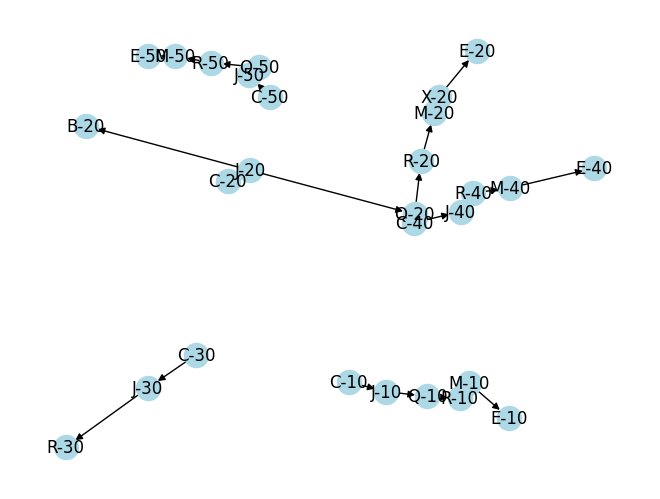

In [35]:
# 그래프 그리기
nx.draw(G, with_labels=True, node_color='lightblue')
plt.show()

------

#### 기본 함수들 정의

그래프 만들기

In [15]:
def build_graph(nodes, edges):
    """노드/엣지 리스트를 받아 Networkx DiGraph 생성"""
    G = nx.DiGraph()
    for node in nodes:
        G.add_node(node['id'], **node.get('attributes', {}))
    for edge in edges:
        G.add_edge(edge['source'], edge['target'], **edge)
    return G

그래프 그리기

In [16]:
def draw_graph(G):
    nx.draw(G, with_labels=True, node_color='lightblue')
    plt.show()

서브 그래프 만들기

In [14]:
def build_subgraph(G, node_ids):
    """특정 노드들만 포함하는 서브그래프 반환"""
    #필터링된 노드들만 포함된 부분 그래프를 만들고 싶다면 node_ids = filtered['id'].tolist()를 선행
    subG = G.subgraph(node_ids).copy()
    return subG

-------------

### A. Node Based Search

1. 특정 노드 검색 - 속성 기반 검색도 가능

In [38]:
def filter_by_node_ids(G, node_ids=None):
    """주어진 노드 ID 리스트에 해당하는 노드들만 반환"""
    if not node_ids:
        return list(G.nodes(data=True))
    return [(nid, G.nodes[nid]) for nid in node_ids if nid in G.nodes]

2. 특정 속성을 가지는 노드 검색

In [41]:
def filter_by_attrs(G, attrs):
    if not attrs or not isinstance(attrs, dict):
        return list(G.nodes(data=True))
    
    results = []
    for node_id, data in G.nodes(data=True):
        match = True
        for key, value in attrs.items():
            node_val = str(data.get(key, "")).lower()
            if str(value).lower() not in node_val:
                match = False
                break
        if match:
            results.append((node_id, data))
    return results

k-hop search

1) single_source 활용

In [ ]:
def k_hop_search(G, sources, k, direction='out'):
    if direction == 'in':
        search_graph = G.reverse(copy=False)
    elif direction == 'both':
        search_graph = G.to_undirected()
    else:
        search_graph = G
    
    all_nodes = set()
    for src in sources:
        nodes = nx.single_source_shortest_path_length(search_graph, src, cutoff=k)
        all_nodes.update(nodes.keys())
    
    subG = build_subgraph(G, all_nodes)
    return subG

2. multi_source 활용

In [46]:
def k_hop_multi_source_search(G, sources, k, direction='out'):
    """multi-source BFS 기반 k-hop 탐색"""
    if direction == 'in':
        search_graph = G.reverse(copy=False)
    elif direction == 'both':
        search_graph = G.to_undirected()
    else:
        search_graph = G

    nodes_within_k = nx.multi_source_shortest_path_length(search_graph, sources, cutoff=k)
    filtered_nodes = list(nodes_within_k.keys())

    subG = build_subgraph(G, filtered_nodes)
    return subG


전체

In [45]:
def filter_nodes(G, node_ids=None, parent=None, attrs=None):   #나중에 type이 parent가 될 수 있음
    # id 기준 노드 검색
    filtered_nodes = filter_by_node_ids(G, node_ids)

    # 속성 기준 노드 검색 - 그룹 포함
    if attrs:
        final_nodes = filter_by_attrs(G, attrs)
        return final_nodes
    
    return filtered_nodes

### B. Edge Based Search

1.  노드와 노드 간 경로 탐색 - 최단 경로

In [ ]:
def find_shortest_path(G, source, target):
    """두 노드 간 최단 경로 탐색"""
    try:
        path = nx.shortest_path(G, source=source, target=target)
        return path
    except nx.NetworkXNoPath:
        return []

2. 그룹과 그룹 간 경로 탐색 - 최단 경로

In [47]:
def find_shortest_path_between_parents(G, parent_a, parent_b):
    """두 parent 그룹 간 최단 경로 탐색"""
    
    # parent별 노드 목록 가져오기
    nodes_a = [n for n, d in G.nodes(data=True) if d.get("parent") == parent_a]
    nodes_b = [n for n, d in G.nodes(data=True) if d.get("parent") == parent_b]
    
    if not nodes_a or not nodes_b:
        return None

    # parent A의 각 노드 → parent B의 각 노드 조합 탐색
    shortest_path = None
    min_length = float("inf")

    for src in nodes_a:
        for tgt in nodes_b:
            try:
                path = nx.shortest_path(G, source=src, target=tgt)
                if len(path) < min_length:
                    min_length = len(path)
                    shortest_path = path
            except nx.NetworkXNoPath:
                continue

    return shortest_path

-----

경로 탐색

In [ ]:
def find_shortest_path(G, source, target):
    """두 노드 간 최단 경로 탐색"""
    try:
        path = nx.shortest_path(G, source=source, target=target)
        return path
    except nx.NetworkXNoPath:
        return []

k-hop 탐색 - 모든 방향 고려

In [61]:
def k_hop_search(G, source, k, direction='out', attr_filter = None):
    """k hop 이내 노드, 경로 탐색"""
    
    if direction == 'in':
        search_graph = G.reverse(copy=False)
    elif direction == 'both':
        search_graph = G.to_undirected()
    else:
        search_graph = G
    
    # k-hop 이내 노드 탐색
    nodes_within_k = nx.single_source_shortest_path_length(search_graph, source=source, cutoff=k)
    filtered_nodes = list(nodes_within_k.keys())


    # 속성 필터 적용
    if attr_filter:
        filtered_nodes = [
            n for n in filtered_nodes
            if all(G.nodes[n].get(key) == val for key, val in attr_filter.items())
        ]

    #subgraph
    subG = build_subgraph(G, filtered_nodes)

    return subG
    

속성 기반 필터링

In [58]:
def filter_by_attributes(G, filters):
    """노드 속성 기반 필터링"""
    filtered_nodes = [
        n for n, attrs in G.nodes(data=True)
        if all(attrs.get(key) == val for key, val in filters.items())
    ]

    return filtered_nodes

노드 필터링

In [46]:
def filter_by_node(G, node_ids):
    if isinstance(node_ids, str):
        node_ids = [node_ids]
    
    filtered_nodes = [n for n in node_ids if n in G]
    if not filtered_nodes:
        return {"nodes": [], "edges": []}
    
    nodes_data = []
    for n in filtered_nodes:
        attr = G.nodes[n]
        nodes_data.append({
            "id": n,
            "label": attr.get("label"),
            "attributes": {k : v for k, v in attr.items() if k != 'label'}
        })
    
    return {"nodes": nodes_data, "edges": []}

In [90]:
def filter_graph(G, query=None, label=None, name=None):
    results = []

    for node_id, data in G.nodes(data=True):
        if (
            (query and query.lower() in node_id.lower())
            or (label and data.get("label", "").lower() == label.lower())
            or (name and name.lower() in data.get("name", "").lower())
            or (query and any(query.lower() in str(v).lower() for v in data.values()))
        ):
            results.append((node_id, data))
    return results


In [ ]:
def filter_graph(G, query=None, label=None, name=None):
    """
    query: dict | None
        e.g. {"region": "Seoul", "status": "Completed"}
    label: str | None
        e.g. "C"
    name: str | None
        e.g. "Invoice"
    """

    results = []

    for node_id, data in G.nodes(data=True):
        match = True

        # label 필터
        if label and data.get("label", "").lower() != label.lower():
            match = False

        # name 필터
        if name and name.lower() not in data.get("name", "").lower():
            match = False

        # attributes 필터 (딕셔너리 형태)
        if query and isinstance(query, dict):
            for key, value in query.items():
                node_val = str(data.get(key, "")).lower()
                if str(value).lower() not in node_val:
                    match = False
                    break

        if match:
            results.append((node_id, data))

    return results


JSON 변환

In [43]:
def convert_graph_to_json(G):
    """Networkx 그래프 객체를 JSON(dict)으로 변환"""
    nodes = []
    for n, attrs in G.nodes(data=True):
        nodes.append({
            'id': n,
            'label': attrs.get('label'),
            'attributes': {k: v for k, v in attrs.items() if k != 'label'}
        })

    edges = []
    for u, v, data in G.edges(data=True):
        edges.append({
            'source': u,
            'taget': v,
            **data
        })

    return {"nodes": nodes, "edges": edges}

테스트

In [ ]:
result =filter_by_node(G, ["C-10", "R-20"])
print(json.dumps(result, indent=2, ensure_ascii=False))

{
  "nodes": [
    {
      "id": "C-10",
      "label": null,
      "attributes": {
        "doc_no": "0000000001",
        "item": "10",
        "material": "FERT001",
        "description": "GRANDEUR",
        "status": "Completed",
        "value": 292000000,
        "time": "2024-02-14",
        "customer": "C0010",
        "region": "Seoul"
      }
    },
    {
      "id": "R-20",
      "label": null,
      "attributes": {
        "doc_no": "4900000002",
        "item": "20",
        "status": "Completed",
        "value": 180000000,
        "time": "2024-03-03"
      }
    }
  ],
  "edges": []
}


In [101]:
#  라벨만 기준
filter_graph(G, label="C")

# 이름 + 속성 조합
filter_graph(G, name="Invoice", query={"status": "Completed"})

# 다중 attributes
filter_graph(G, label="C", query={"region": "Seoul", "status": "Completed"})

# 특정 키워드 없는 경우에도 안전하게 동작
#filter_graph(G, query={"region": "Daegu"})


[('C-10',
  {'doc_no': '0000000001',
   'item': '10',
   'material': 'FERT001',
   'description': 'GRANDEUR',
   'status': 'Completed',
   'value': 292000000,
   'time': '2024-02-14',
   'customer': 'C0010',
   'region': 'Seoul',
   'label': 'C',
   'name': 'Sales Order'}),
 ('C-50',
  {'doc_no': '0000000005',
   'item': '10',
   'material': 'FERT005',
   'description': 'GENESIS',
   'status': 'Completed',
   'value': 520000000,
   'time': '2024-03-20',
   'customer': 'C0040',
   'region': 'Seoul',
   'label': 'C',
   'name': 'Sales Order'})]

In [59]:
attr_filter = {"status": "Completed", "region": "Seoul"}
result = filter_by_attributes(G, attr_filter)
result

['C-10', 'C-50']

DiGraph with 6 nodes and 5 edges


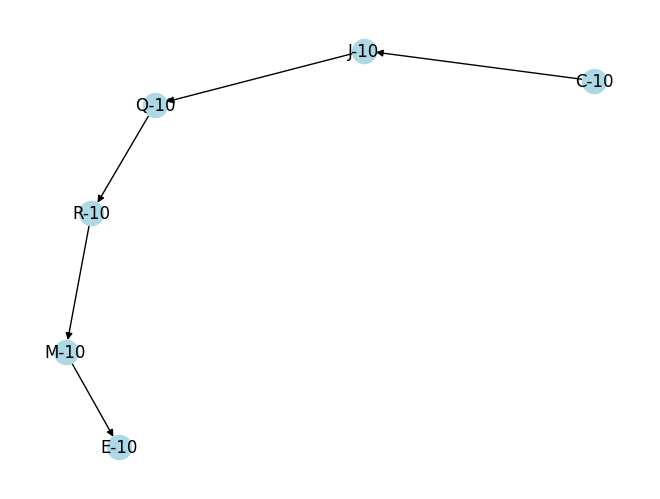

In [76]:
k_hop_attr_filter = k_hop_search(G, 'R-10', k=3, attr_filter={'status': 'Completed'})
k_hop_attr_filter_graph = k_hop_search(G, 'R-10', k=3, direction='both')
print(k_hop_attr_filter_graph)

draw_graph(k_hop_attr_filter_graph)

In [ ]:

find_shortest_path(G, 'C-10', 'E-10')

['C-10', 'J-10', 'Q-10', 'R-10', 'M-10', 'E-10']